# Import Libraries and Datasets

In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.metrics import confusion_matrix

# Import Datasets
df = pd.read_csv('../data/processed/data_processed.csv')

# Create Function

In [256]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calculate the accuracy, precision, recall, and F1 score
def get_test_metrics(y_test, y_pred, y_prob):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'AUC: {auc:.4f}')

# Classification models (data_processed)

## Use Tree base model to select features （要刪除）

In [266]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['FraudFound_P'])
y = df['FraudFound_P']

# 將train, validation, test data 切成 70%, 15%, 15%
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [267]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

In [268]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)

lgbm.fit(X_rus, y_rus)
y_pred = lgbm.predict(X_valid)
y_prob = lgbm.predict_proba(X_valid)[:, 1]

get_test_metrics(y_valid, y_pred, y_prob)

Accuracy: 0.6857
Precision: 0.1423
Recall: 0.8417
F1 Score: 0.2435
AUC: 0.8230


/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



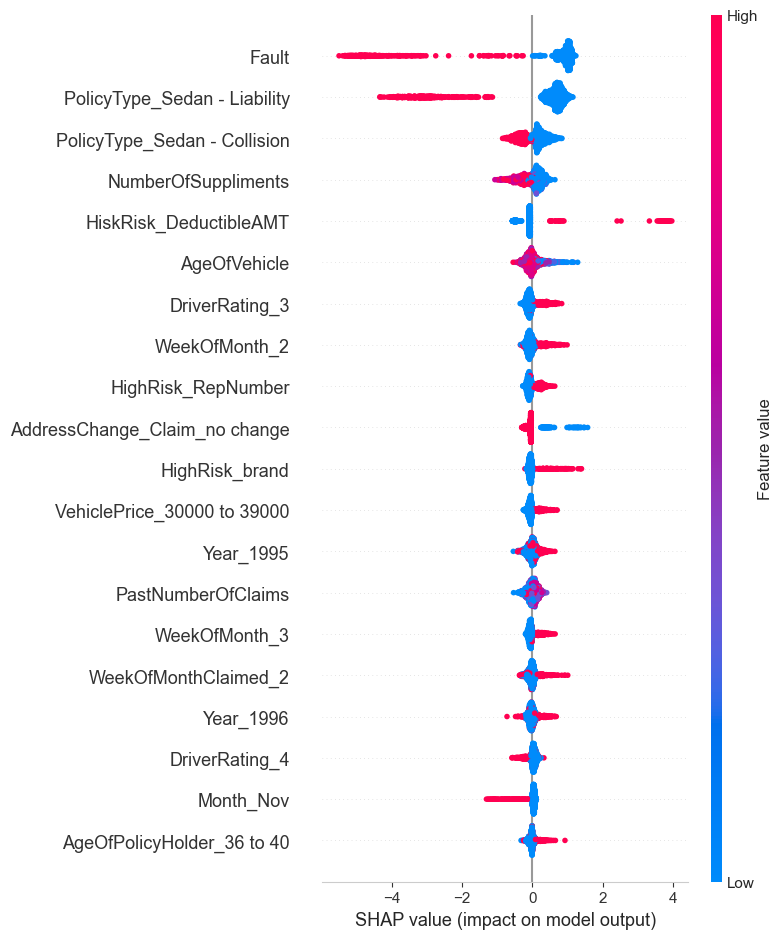

In [269]:
import numpy as np
import shap

# Create explainer object
explainer = shap.TreeExplainer(lgbm)

shap_values = explainer.shap_values(X_rus)
shap.summary_plot(shap_values, X_rus)  

# Get mean absolute SHAP values for each feature
shap_importance = pd.DataFrame({
    'Feature': X_rus.columns,
    'SHAP_importance': np.abs(shap_values).mean(axis=0)
})


# 先排序一次
sorted_features = shap_importance.sort_values('SHAP_importance', ascending=False)
# 創建特徵字典
feature_dict = {
    'top_20_features': sorted_features.head(20)['Feature'].tolist(),
    'top_30_features': sorted_features.head(30)['Feature'].tolist(),
    'top_40_features': sorted_features.head(40)['Feature'].tolist(),
    'top_50_features': sorted_features.head(50)['Feature'].tolist(),
    'top_60_features': sorted_features.head(60)['Feature'].tolist(),
    'top_70_features': sorted_features.head(70)['Feature'].tolist()
}

In [270]:
for feature_name, features in feature_dict.items():
    X_rus_selected = X_rus[features]
    X_valid_selected = X_valid[features]

    lgbm = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)

    lgbm.fit(X_rus_selected, y_rus)
    y_pred = lgbm.predict(X_valid_selected)
    y_prob = lgbm.predict_proba(X_valid_selected)[:, 1]

    print(f"\nResults for {feature_name}:")
    get_test_metrics(y_valid, y_pred, y_prob)


Results for top_20_features:
Accuracy: 0.6597
Precision: 0.1241
Recall: 0.7698
F1 Score: 0.2138
AUC: 0.7867

Results for top_30_features:
Accuracy: 0.6827
Precision: 0.1332
Recall: 0.7770
F1 Score: 0.2274
AUC: 0.8007

Results for top_40_features:
Accuracy: 0.6874
Precision: 0.1386
Recall: 0.8058
F1 Score: 0.2365
AUC: 0.8069

Results for top_50_features:
Accuracy: 0.6835
Precision: 0.1397
Recall: 0.8273
F1 Score: 0.2391
AUC: 0.8148

Results for top_60_features:
Accuracy: 0.6891
Precision: 0.1420
Recall: 0.8273
F1 Score: 0.2424
AUC: 0.8216

Results for top_70_features:
Accuracy: 0.6883
Precision: 0.1443
Recall: 0.8489
F1 Score: 0.2466
AUC: 0.8271


## Use RFECV model to select features

In [389]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['FraudFound_P'])
y = df['FraudFound_P']

# 將train, validation, test data 切成 80%, 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [390]:
# Create a baseline model without any processing first
# Create XGBoost classifier
xgb_base = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, eval_metric='logloss')

# Train the model
xgb_base.fit(X_train, y_train)

# Make predictions
y_pred = xgb_base.predict(X_test)
y_prob = xgb_base.predict_proba(X_test)[:, 1]

get_test_metrics(y_test, y_pred, y_prob)


Accuracy: 0.9413
Precision: 0.7500
Recall: 0.0324
F1 Score: 0.0622
AUC: 0.8492


In [391]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

Optimal number of features: 21

Selected features:
AgeOfPolicyHolder_41 to 50
Fault
PoliceReportFiled
PolicyType_Sedan - Collision
PolicyType_Sedan - Liability
HiskRisk_DeductibleAMT
Month_Dec
Month_Mar
WeekOfMonth_2
WeekOfMonth_3
WeekOfMonth_4
DayOfWeek_Sunday
Year_1995
Year_1996
MonthClaimed_Aug
MonthClaimed_Dec
MonthClaimed_Feb
MonthClaimed_Jan
MonthClaimed_Jun
MonthClaimed_Nov
WeekOfMonthClaimed_2


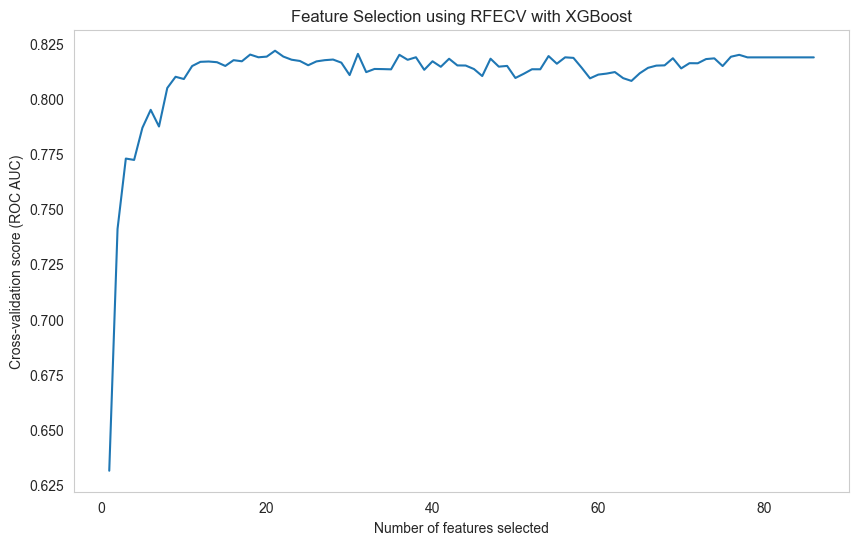

In [392]:
# Use RFECV with XGBoost for feature selection
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Initialize XGBoost classifier
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, eval_metric='logloss')

# Initialize RFECV
rfecv = RFECV(
    estimator=xgb,
    step=1,
    cv=5,
    scoring='roc_auc',
    min_features_to_select=1,
    n_jobs=1
)

# Fit RFECV
rfecv.fit(X_train_rus, y_train_rus)

# Get selected features
selected_features = X_train_rus.columns[rfecv.support_]

print(f"Optimal number of features: {rfecv.n_features_}")
print("\nSelected features:")
for feature in selected_features:
    print(feature)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xlabel('Number of features selected')
plt.ylabel('Cross-validation score (ROC AUC)')
plt.title('Feature Selection using RFECV with XGBoost')
plt.show()



In [393]:
X_train_rus_selected = X_train_rus[selected_features]
X_test_selected = X_test[selected_features]
X_train_rus_selected.shape

(1476, 21)

In [394]:
# Train XGBoost model on selected features --> best so far
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, eval_metric='logloss')
xgb.fit(X_train_rus_selected, y_train_rus)

# Make predictions on test set
y_pred = xgb.predict(X_test_selected)
y_prob = xgb.predict_proba(X_test_selected)[:, 1]

# Get performance metrics
get_test_metrics(y_test, y_pred, y_prob)

Accuracy: 0.7004
Precision: 0.1543
Recall: 0.8919
F1 Score: 0.2632
AUC: 0.8527


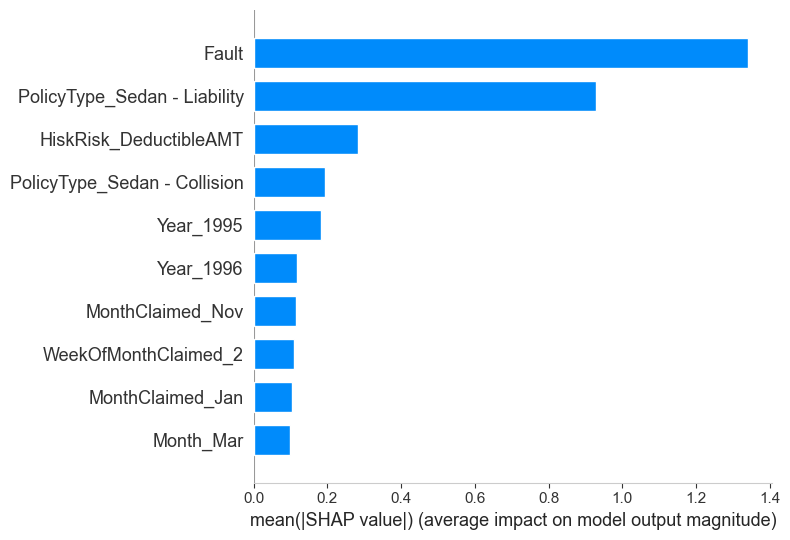

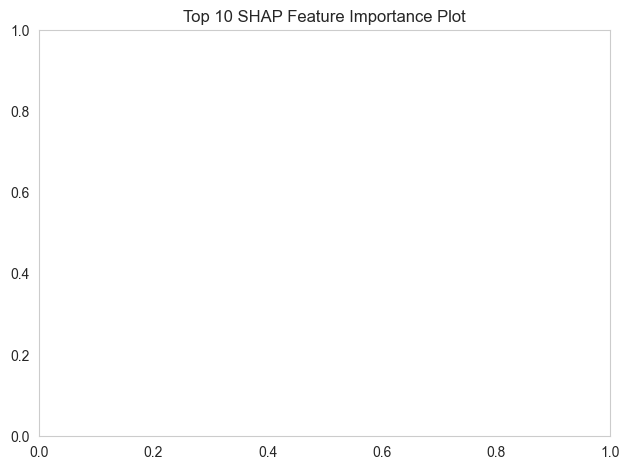

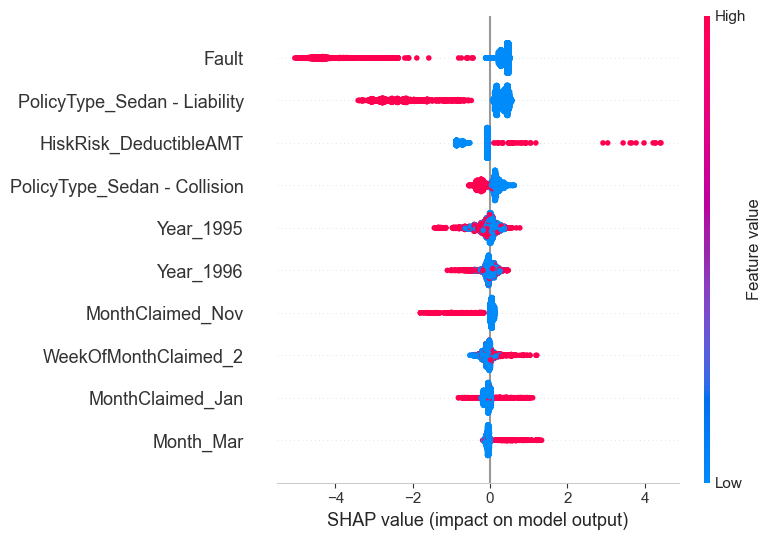

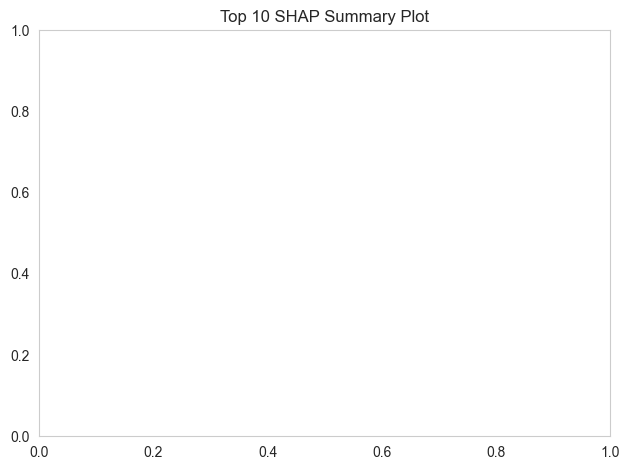

In [399]:
# Calculate SHAP values
import shap
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_selected)

# Create bar summary plot showing top 10 important features
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_selected, plot_type="bar", max_display=10)
plt.title("Top 10 SHAP Feature Importance Plot")
plt.tight_layout()
plt.show()

# Create detailed SHAP summary plot showing feature impacts for top 10 features
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_selected, max_display=10)
plt.title("Top 10 SHAP Summary Plot")
plt.tight_layout() 
plt.show()


## Ensemble models （要刪除）

In [274]:
# 使用30個features，在模型表現及複雜度之間取得一個較好的平衡
X = df.drop(columns = ['FraudFound_P'])
X_selected = X[feature_dict['top_30_features']]
y = df['FraudFound_P']

# 將train, validation, test data 切成 70%, 15%, 15%
X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y, test_size = 0.3, random_state = 42, stratify = y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [275]:
# Train a Balanced Bagging Classifier (base model: LGBM)
import lightgbm as lgb
from imblearn.ensemble import BalancedBaggingClassifier

lgbm = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)
balbag = BalancedBaggingClassifier(estimator = lgbm, n_estimators=100, bootstrap = True,
                                   bootstrap_features = True, sampling_strategy = 'majority', replacement = True,
                                   n_jobs = 1, random_state = 42)

balbag.fit(X_train, y_train)
y_pred = balbag.predict(X_valid)
y_prob = balbag.predict_proba(X_valid)[:, 1]

get_test_metrics(y_valid, y_pred, y_prob)

Accuracy: 0.6982
Precision: 0.1394
Recall: 0.7770
F1 Score: 0.2363
AUC: 0.8147


In [276]:
# Train a Balanced Bagging Classifier (base model: XGBoost)
import xgboost as xgb
from imblearn.ensemble import BalancedBaggingClassifier

# Create and train XGBoost classifier
xgb = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
balbag = BalancedBaggingClassifier(estimator = xgb, n_estimators=500, bootstrap = True,
                                   bootstrap_features = True, sampling_strategy = 'majority', replacement = True,
                                   n_jobs = 1, random_state = 42)

balbag.fit(X_train, y_train)
y_pred = balbag.predict(X_valid)
y_prob = balbag.predict_proba(X_valid)[:, 1]

get_test_metrics(y_valid, y_pred, y_prob)

Accuracy: 0.6814
Precision: 0.1389
Recall: 0.8273
F1 Score: 0.2378
AUC: 0.8196


In [277]:
# Train a Balanced Random Foresr model
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(n_estimators=500, random_state=42)
brf.fit(X_train, y_train)
y_pred = brf.predict(X_valid)
y_prob = brf.predict_proba(X_valid)[:, 1]

get_test_metrics(y_valid, y_pred, y_prob)


/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning:

The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.

/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning:

The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.

/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning:

The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the impleme

Accuracy: 0.6304
Precision: 0.1286
Recall: 0.8921
F1 Score: 0.2248
AUC: 0.8189


In [278]:
# Train an EasyEnsemble Classifier
from imblearn.ensemble import EasyEnsembleClassifier

ee = EasyEnsembleClassifier(n_estimators=100, random_state=42)
ee.fit(X_train, y_train)
y_pred = ee.predict(X_valid)
y_prob = ee.predict_proba(X_valid)[:, 1]

get_test_metrics(y_valid, y_pred, y_prob)


Accuracy: 0.5988
Precision: 0.1254
Recall: 0.9496
F1 Score: 0.2215
AUC: 0.8019


在三個模型中，由Balanced Bagging Classifier在AUC表現較好，在Recall有0.8以上，precision也有0.15以上，取得一個不錯的平衡。  
下面會選擇較符合詐欺偵測適合的閾值。


In [137]:
# 設定閾值範圍
thresholds = np.linspace(0.1, 0.9, 50)

best_threshold = 0.5  # 初始閾值
best_f1 = 0

for threshold in thresholds:
    y_pred_adjusted = (y_prob >= threshold).astype(int)
    precision = precision_score(y_valid, y_pred_adjusted)
    recall = recall_score(y_valid, y_pred_adjusted)
    f1 = f1_score(y_valid, y_pred_adjusted)
    print(f"Threshold: {threshold:.2f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    # 更新最佳閾值
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nBest Threshold: {best_threshold:.2f}, Best F1-score: {best_f1:.4f}")

Threshold: 0.10, Precision: 0.0614, Recall: 1.0000, F1-score: 0.1157
Threshold: 0.12, Precision: 0.0622, Recall: 1.0000, F1-score: 0.1171
Threshold: 0.13, Precision: 0.0636, Recall: 1.0000, F1-score: 0.1196
Threshold: 0.15, Precision: 0.0656, Recall: 1.0000, F1-score: 0.1231
Threshold: 0.17, Precision: 0.0680, Recall: 1.0000, F1-score: 0.1273
Threshold: 0.18, Precision: 0.0709, Recall: 0.9928, F1-score: 0.1324
Threshold: 0.20, Precision: 0.0752, Recall: 0.9928, F1-score: 0.1399
Threshold: 0.21, Precision: 0.0813, Recall: 0.9928, F1-score: 0.1503
Threshold: 0.23, Precision: 0.0871, Recall: 0.9856, F1-score: 0.1600
Threshold: 0.25, Precision: 0.0935, Recall: 0.9856, F1-score: 0.1708
Threshold: 0.26, Precision: 0.0999, Recall: 0.9856, F1-score: 0.1815
Threshold: 0.28, Precision: 0.1060, Recall: 0.9856, F1-score: 0.1913
Threshold: 0.30, Precision: 0.1114, Recall: 0.9784, F1-score: 0.2000
Threshold: 0.31, Precision: 0.1170, Recall: 0.9784, F1-score: 0.2091
Threshold: 0.33, Precision: 0.1190

/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this beh

我選擇 0.41作為threshold，因為在詐欺偵測的問題中，False negative成本通常比False positive高上許多，  
因此在這個threshold下，能夠捕捉90%以上的詐欺案件，精確率為13.22%。  

將這個閾值及模型運用在test data上

In [140]:
# 使用0.41閾值預測test data
y_test_prob = ee.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob >= 0.41).astype(int)

# 取得測試集的評估指標
get_test_metrics(y_test, y_test_pred, y_test_prob)


Accuracy: 0.5884
Precision: 0.1217
Recall: 0.9493
F1 Score: 0.2158
AUC: 0.7869


## Ensemble Models (use CV)

In [401]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [402]:
# Train a Balanced Bagging Classifier (base model: XGBoost)
import xgboost as xgb
from imblearn.ensemble import BalancedBaggingClassifier

# Create and train XGBoost classifier
xgb = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, eval_metric='logloss')
balbag = BalancedBaggingClassifier(estimator = xgb, n_estimators=500, bootstrap = True,
                                   bootstrap_features = True, sampling_strategy = 'majority', replacement = True,
                                   n_jobs = 1, random_state = 42)

balbag.fit(X_train_selected, y_train)
y_pred = balbag.predict(X_test_selected)
y_prob = balbag.predict_proba(X_test_selected)[:, 1]

get_test_metrics(y_test, y_pred, y_prob)

Accuracy: 0.6962
Precision: 0.1557
Recall: 0.9189
F1 Score: 0.2662
AUC: 0.8559


In [378]:
# Calculate permutation importance
from sklearn.inspection import permutation_importance
import plotly.graph_objects as go

# Perform permutation importance calculation
result = permutation_importance(balbag, X_test_selected, y_test, 
                              n_repeats=10, 
                              random_state=42,
                              n_jobs=1)

# Create dataframe of feature importances
importances = pd.DataFrame(
    {'feature': selected_features,
     'importance_mean': result.importances_mean}
)

# Sort features by mean importance and get top 10
importances = importances.sort_values('importance_mean', ascending=True).tail(10)

# Create plotly horizontal bar chart
fig = go.Figure(go.Bar(
    x=importances['importance_mean'],
    y=importances['feature'],
    orientation='h'
))

fig.update_layout(
    title='Feature Importance (Permutation) - Top 10 Features',
    xaxis_title='Permutation Importance',
    yaxis_title='Features',
    height=600,
    width=800
)

fig.show()

In [365]:
# # Train an EasyEnsemble classifier
# from imblearn.ensemble import EasyEnsembleClassifier

# ee = EasyEnsembleClassifier(n_estimators=100, random_state=42)
# ee.fit(X_train_selected, y_train)
# y_pred = ee.predict(X_test_selected)
# y_prob = ee.predict_proba(X_test_selected)[:, 1]

# get_test_metrics(y_test, y_pred, y_prob)


Accuracy: 0.5911
Precision: 0.1232
Recall: 0.9514
F1 Score: 0.2182
AUC: 0.8060


## Stacking Enseble Model

In [156]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['FraudFound_P'])
y = df['FraudFound_P']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [143]:
# Train a Balanced Bagging Classifier (base model: LGBM)
import lightgbm as lgb
from imblearn.ensemble import BalancedBaggingClassifier

lgbm = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)
balbag = BalancedBaggingClassifier(estimator = lgbm, n_estimators=100, bootstrap = True,
                                   bootstrap_features = True, sampling_strategy = 'majority', replacement = True,
                                   n_jobs = -1, random_state = 42)

balbag.fit(X_train, y_train)
y_pred_balbag = balbag.predict(X_test)
y_prob_balbag = balbag.predict_proba(X_test)[:, 1]

get_test_metrics(y_test, y_pred_balbag, y_prob_balbag)

Accuracy: 0.7575
Precision: 0.1645
Recall: 0.7459
F1 Score: 0.2695
AUC: 0.8434


In [144]:
# Train a Balanced Random Foresr model
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train, y_train)
y_pred_brf = brf.predict(X_test)
y_prob_brf = brf.predict_proba(X_test)[:, 1]

get_test_metrics(y_test, y_pred_brf, y_prob_brf)

/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow 

Accuracy: 0.6521
Precision: 0.1402
Recall: 0.9351
F1 Score: 0.2438
AUC: 0.8398


In [145]:
# Train an EasyEnsemble Classifier
from imblearn.ensemble import EasyEnsembleClassifier

ee = EasyEnsembleClassifier(n_estimators=100, random_state=42)
ee.fit(X_train, y_train)
y_pred_ee = ee.predict(X_test)
y_prob_ee = ee.predict_proba(X_test)[:, 1]

get_test_metrics(y_test, y_pred_ee, y_prob_ee)

Accuracy: 0.5957
Precision: 0.1255
Recall: 0.9622
F1 Score: 0.2221
AUC: 0.8060


In [149]:
# Train a XGboost
# Train XGBoost model
import xgboost as xgb

# Create and train XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]), # Handle class imbalance
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Get metrics
get_test_metrics(y_test, y_pred_xgb, y_prob_xgb)


Accuracy: 0.8019
Precision: 0.1895
Recall: 0.7027
F1 Score: 0.2985
AUC: 0.8528


In [151]:
# Train a Balanced Bagging Classifier (base model: XGboost)
from imblearn.ensemble import BalancedBaggingClassifier
import xgboost as xgb

# Create and train XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
balbag = BalancedBaggingClassifier(estimator = xgb_model, n_estimators=100, bootstrap = True,
                                   bootstrap_features = True, sampling_strategy = 'majority', replacement = True,
                                   n_jobs = -1, random_state = 42)

balbag.fit(X_train, y_train)
y_pred_balbag = balbag.predict(X_test)
y_prob_balbag = balbag.predict_proba(X_test)[:, 1]

get_test_metrics(y_test, y_pred_balbag, y_prob_balbag)

Accuracy: 0.7354
Precision: 0.1559
Recall: 0.7730
F1 Score: 0.2595
AUC: 0.8432


In [155]:
# Train a Balanced Bagging Classifier (base model: Random Forest)
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# Create and train Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    random_state=42,
    criterion = 'entropy'
)
balbag = BalancedBaggingClassifier(estimator=rf_model, n_estimators=100, bootstrap=True,
                                   bootstrap_features=True, sampling_strategy='majority', replacement=True,
                                   n_jobs=-1, random_state=42)

balbag.fit(X_train, y_train)
y_pred_balbag = balbag.predict(X_test)
y_prob_balbag = balbag.predict_proba(X_test)[:, 1]

get_test_metrics(y_test, y_pred_balbag, y_prob_balbag)

Accuracy: 0.6388
Precision: 0.1305
Recall: 0.8865
F1 Score: 0.2275
AUC: 0.8178


In [147]:
# Train a Stacking Classifier combining BalancedBagging, BalancedRandomForest and EasyEnsemble
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

# Define base estimators
estimators = [
    ('balbag', balbag),
    ('brf', brf), 
    ('ee', ee)
]

# Create stacking classifier with logistic regression as final estimator
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    cv=5,
    n_jobs=-1
)

# Fit stacking classifier
stack.fit(X_train, y_train)

# Make predictions
y_pred_stack = stack.predict(X_test)
y_prob_stack = stack.predict_proba(X_test)[:, 1]

# Get metrics for stacked model
get_test_metrics(y_test, y_pred_stack, y_prob_stack)


/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow 

Accuracy: 0.9384
Precision: 0.3810
Recall: 0.0432
F1 Score: 0.0777
AUC: 0.8008


# Anomaly Detection (data_processed)

## Isolation Forest

In [250]:
# 先結合X_train與y_train，因為異常偵測算法只使用正常資料訓練
df_train = pd.concat([X_train, pd.DataFrame(y_train, columns=['FraudFound_P'])], axis = 1)

# 將訓練集分成正常樣本（多數類別）和異常樣本（少數類別）
df_train_normal = df_train[df_train['FraudFound_P'] == 0]
df_train_anomaly = df_train[df_train['FraudFound_P'] == 1]

# 分離特徵跟目標變數（非監督學習訓練時只用到正常樣本的特徵)
X_train_normal = df_train_normal.drop(columns = 'FraudFound_P')

In [118]:
from sklearn.ensemble import IsolationForest

# 詐欺樣本比例為6%，contimination設為0.06
iso_forest = IsolationForest(contamination=0.06, random_state=42)  

# 訓練模型（僅使用正常樣本）
iso_forest.fit(X_train_normal)

IsolationForest(contamination=0.06, random_state=42)

/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


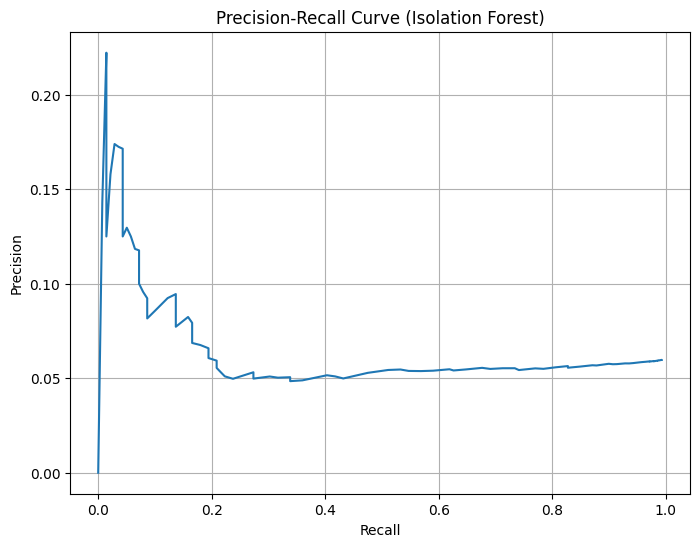

In [122]:
# 在驗證集上預測異常分數
y_valid_scores = iso_forest.decision_function(X_valid)  # 產生異常分數

# 計算不同閾值下的precision和recall
thresholds = np.linspace(y_valid_scores.min(), y_valid_scores.max(), 100)
precisions = []
recalls = []

for threshold in thresholds:
    # 將異常分數轉換為預測標籤 (小於閾值為異常=1，大於閾值為正常=0)
    y_pred = (y_valid_scores < threshold).astype(int)
    
    # 計算precision和recall
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    
    precisions.append(precision)
    recalls.append(recall)

# 繪製precision-recall曲線
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Isolation Forest)')
plt.grid(True)
plt.show()


## One-Class SVM

In [124]:
from sklearn.svm import OneClassSVM

OSVM = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.1)
OSVM.fit(X_train_normal)

OneClassSVM(gamma=0.1, nu=0.1)

/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


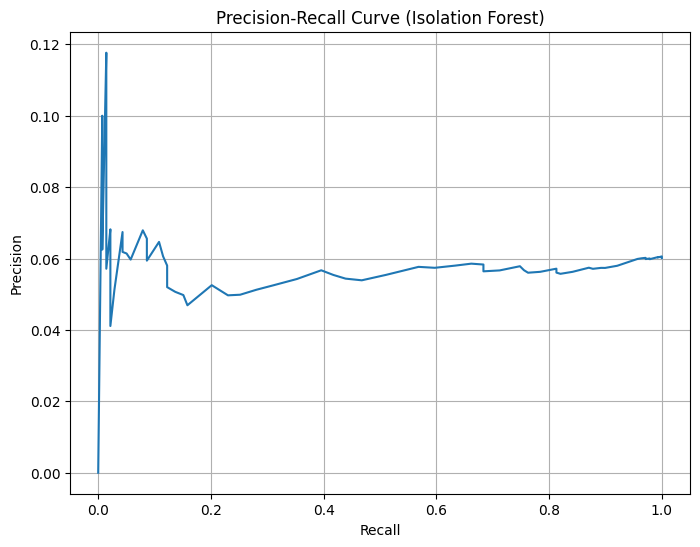

In [125]:
y_valid_scores = OSVM.decision_function(X_valid) #產生異常分數

# 計算不同閾值下的precision和recall
thresholds = np.linspace(y_valid_scores.min(), y_valid_scores.max(), 100)
precisions = []
recalls = []

for threshold in thresholds:
    # 將異常分數轉換為預測標籤 (小於閾值為異常=1，大於閾值為正常=0)
    y_pred = (y_valid_scores < threshold).astype(int)
    
    # 計算precision和recall
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    
    precisions.append(precision)
    recalls.append(recall)

# 繪製precision-recall曲線
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Isolation Forest)')
plt.grid(True)
plt.show()

## AutoEncoders

In [251]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_normal)
X_valid_scaled = scaler.transform(X_valid)

# Build autoencoder model
input_dim = X_train_scaled.shape[1]

autoencoder = Sequential([
    # Encoder
    Dense(16, activation='relu', input_shape=(input_dim,)),
    Dense(8, activation='relu'),
    
    # Decoder
    Dense(16, activation='relu'), 
    Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')


/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [252]:
# Train the model
history = autoencoder.fit(
    X_train_scaled, 
    X_train_scaled,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_valid_scaled, X_valid_scaled),
    verbose=1
)

# Get reconstruction error
train_pred = autoencoder.predict(X_train_scaled)
valid_pred = autoencoder.predict(X_valid_scaled)

train_mse = np.mean(np.power(X_train_scaled - train_pred, 2), axis=1)
valid_mse = np.mean(np.power(X_valid_scaled - valid_pred, 2), axis=1)

Epoch 1/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 708us/step - loss: 1.1624 - val_loss: 0.9693
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.9494 - val_loss: 0.8734
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 0.8562 - val_loss: 0.8181
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 0.8089 - val_loss: 0.7817
Epoch 5/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 0.7723 - val_loss: 0.7617
Epoch 6/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 0.7495 - val_loss: 0.7488
Epoch 7/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 0.7421 - val_loss: 0.7409
Epoch 8/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 0.7298 - val_loss: 0.7347
Epoch 9/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 0.7236 - val_loss: 0.7293
Epoch 10/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 0.7218 - val_loss: 0.7248
Epoch 11/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 0.7207 - val_loss: 0.7189
Epoch 12/50
318/318 ━━━━━━━━━━

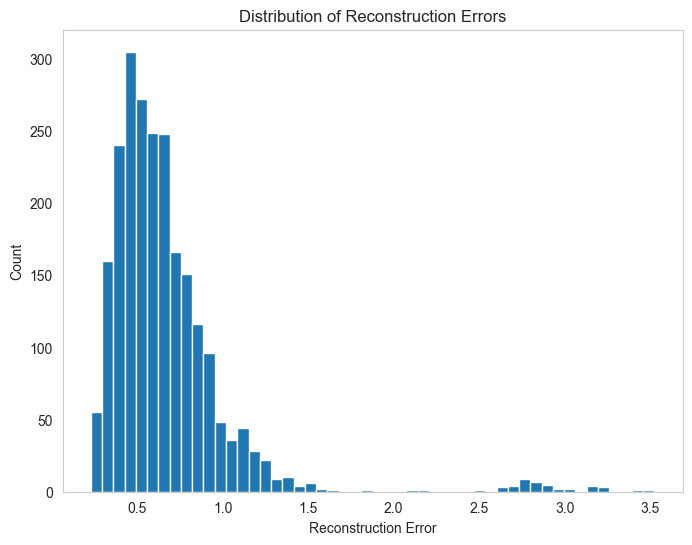

In [253]:
# Plot reconstruction error distribution
plt.figure(figsize=(8, 6))
plt.hist(valid_mse, bins=50)
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.title('Distribution of Reconstruction Errors')
plt.show()

In [254]:
# 設定閾值範圍
thresholds = np.linspace(0.1, 4.0, 50)

best_threshold = 0.1  # 初始閾值
best_f1 = 0

for threshold in thresholds:
    y_pred_adjusted = (valid_mse >= threshold).astype(int)
    precision = precision_score(y_valid, y_pred_adjusted)
    recall = recall_score(y_valid, y_pred_adjusted)
    f1 = f1_score(y_valid, y_pred_adjusted)
    print(f"Threshold: {threshold:.2f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    # 更新最佳閾值
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nBest Threshold: {best_threshold:.2f}, Best F1-score: {best_f1:.4f}")

Threshold: 0.10, Precision: 0.0601, Recall: 1.0000, F1-score: 0.1134
Threshold: 0.18, Precision: 0.0601, Recall: 1.0000, F1-score: 0.1134
Threshold: 0.26, Precision: 0.0598, Recall: 0.9856, F1-score: 0.1127
Threshold: 0.34, Precision: 0.0597, Recall: 0.9281, F1-score: 0.1123
Threshold: 0.42, Precision: 0.0607, Recall: 0.8201, F1-score: 0.1131
Threshold: 0.50, Precision: 0.0574, Recall: 0.6259, F1-score: 0.1052
Threshold: 0.58, Precision: 0.0574, Recall: 0.4964, F1-score: 0.1029
Threshold: 0.66, Precision: 0.0588, Recall: 0.3813, F1-score: 0.1019
Threshold: 0.74, Precision: 0.0647, Recall: 0.3094, F1-score: 0.1070
Threshold: 0.82, Precision: 0.0582, Recall: 0.2014, F1-score: 0.0903
Threshold: 0.90, Precision: 0.0618, Recall: 0.1511, F1-score: 0.0877
Threshold: 0.98, Precision: 0.0805, Recall: 0.1367, F1-score: 0.1013
Threshold: 1.06, Precision: 0.0856, Recall: 0.1151, F1-score: 0.0982
Threshold: 1.13, Precision: 0.0963, Recall: 0.0935, F1-score: 0.0949
Threshold: 1.21, Precision: 0.1111

/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: U

## Plot the distributation

In [173]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['FraudFound_P'])
y = df['FraudFound_P']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [183]:
from sklearn.decomposition import KernelPCA
import plotly.express as px

# 使用 KernelPCA 將特徵降至 3 維
kpca = KernelPCA(n_components=3, kernel='rbf')
kpca_model = kpca.fit(X_train_scaled)
X_train_kpca = kpca_model.transform(X_train_scaled)

# 將降維後的數據轉換為 DataFrame
df_kpca = pd.DataFrame(X_train_kpca, columns=['KPCA1', 'KPCA2', 'KPCA3'])
df_kpca['target'] = y_train  # 添加目標變數

In [197]:
import plotly.express as px
import plotly.graph_objects as go

# 使用 Plotly Express (更簡單的方法)
fig = px.scatter_3d(
    df_kpca,
    x='KPCA1',
    y='KPCA2',
    z='KPCA3',
    color='target',
    title='3D Visualization of KPCA Components',
    labels={'target': 'Fraud'},
    color_discrete_sequence=px.colors.qualitative.Set1
)

# 更新布局
fig.update_layout(
    scene = dict(
        xaxis_title='KPCA 1',
        yaxis_title='KPCA 2',
        zaxis_title='KPCA 3'
    ),
    width=600,
    height=600,
    showlegend=True
)

# 顯示圖形
fig.show()

In [164]:
# 繪製 3D 散點圖
fig = px.scatter_3d(
    df_kpca, 
    x='KPCA1', 
    y='KPCA2', 
    z='KPCA3', 
    color='target',  # 根據目標變數著色
    title="3D Scatter Plot of Positive and Negative Samples after PCA",
    labels={"target": "Class"},
    opacity=0.7,  # 控制透明度以便更好地觀察重疊
    width=900,  # 設定圖片寬度
    height=600   # 設定圖片高度
)

# 顯示圖表
fig.show()

上圖顯示異常偵測方法可能沒辦法很好的分辨詐欺樣本

# Emport the best model so far

In [404]:
# Export the balanced random forest model
import pickle
import os

# Save the model
with open('../app/models/balbag_xgboost.pkl', 'wb') as f:
    pickle.dump(balbag, f)


In [408]:
# export testing data
X_test_selected.to_csv('../data/processed/testing data.csv', index = True)